# Quality assessment of solar irradiance data

It is virtually impossible to make continuous solar irradiance measurements without some amount of missing and erroneously data. While data providers often conduct a basic quality check, users of irradiance data are strongly urged to conduct their own quality assessment, as the necessary level of quality control depends on the application. There exists numerous methods for quality assessment of irradiance time-series. However, there is no commonly agreed upon methodology within the scientific community and hence, each user often ends up with his or her own method of quality assessing data and flagging/removing questionable data.

This section aims at giving an introduction to the most commonly used quality assessment methods and a practical guide in how to apply them.
***
<div style="text-align: right"> <i>Content by Adam R. Jensen & Yves-Marie Saint-Drenan</i> </div>

<br>

## Load data
In order to demonstrate the quality assessment methods which will be introduced in this notebook, some sample data is needed. In the following code block, a one year dataset of GHI, DHI, and DNI from the [Technical University of Denmark](http://climatestationdata.byg.dtu.dk/) is read into a pandas DataFrame. The data file can be downloaded [here](https://github.com/AssessingSolar/AssessingSolar/tree/main/assessingsolar/notebooks/data/solar_irradiance_dtu_2019.csv). It is important to note, that in order to correctly calculate solar angles and sunrise/sunset times, the index must be made timezone aware.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pvlib

data_path = 'data/solar_irradiance_dtu_2019.csv'

df = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
df.index = df.index.tz_localize('UTC')  # Make the index timezone aware
original_entries = df.shape[0]

df.head()  # Print the first five lines of the DataFrame

,GHI,DHI,DNI,zenith,azimuth
Time(utc),,,,,
2019-01-01 00:00:00+00:00,-0.2,-0.2,-0.1,146.1,19.6
2019-01-01 00:01:00+00:00,-0.2,-0.2,-0.1,146.1,20.0
2019-01-01 00:02:00+00:00,-0.1,-0.2,-0.0,146.0,20.4
2019-01-01 00:03:00+00:00,-0.1,-0.2,-0.1,146.0,20.8
2019-01-01 00:04:00+00:00,-0.2,-0.2,-0.1,145.9,21.2


<br>

## Visual inspection
As a first check it is important to visualize the data, in order to ensure that the data has been loaded as expected and to detect major issues. For this purpose, the different measurements have been plotted as a function of time, as well as a histogram. Generally, this first qualitative analysis allows detecting major issues in the data set. Nevertheless, it is not possible to judge their plausibility at this stage of the data analysis.

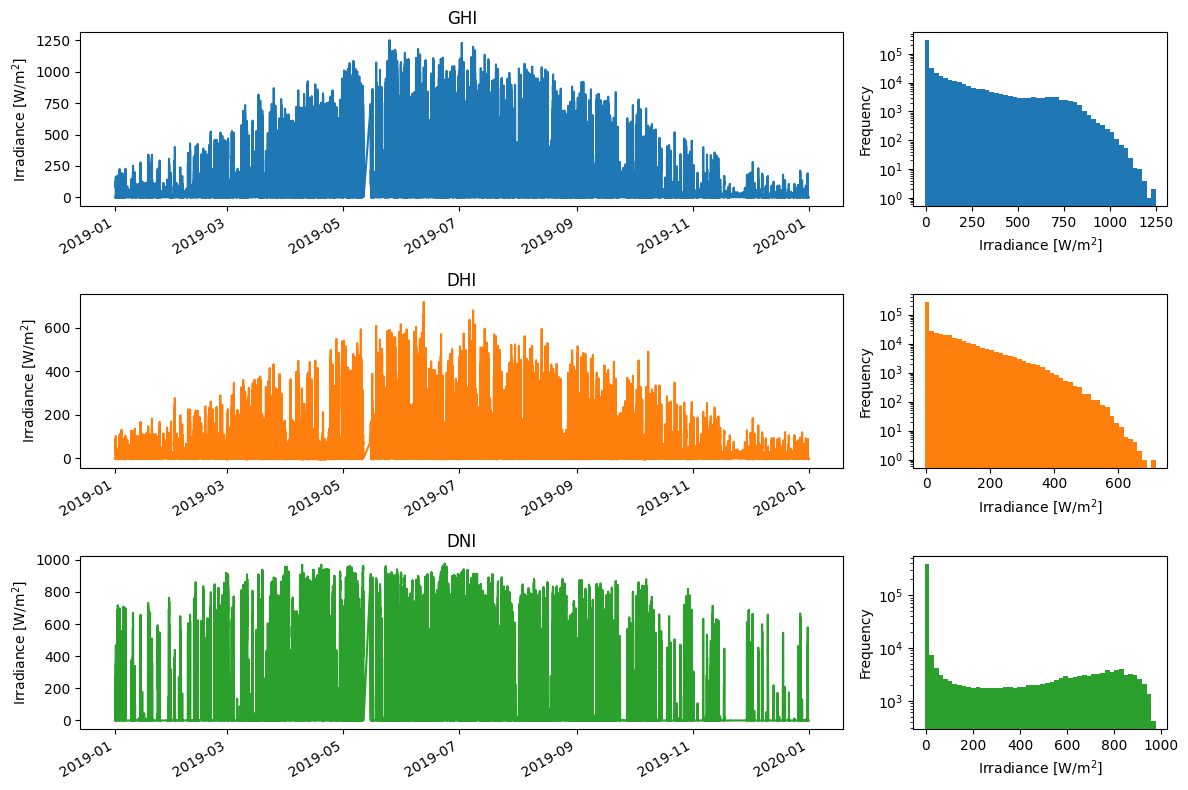

In [2]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), gridspec_kw={'width_ratios':[3,1]})
for i, c in enumerate(['GHI','DHI','DNI']):
    df[c].plot(ax=axes[i,0], c='C{}'.format(i), title=c)
    df[c].plot.hist(ax=axes[i,1], logy=True, bins=50, facecolor='C{}'.format(i))
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel('Irradiance [W/m$^2$]')
    axes[i,1].set_xlabel('Irradiance [W/m$^2$]')
fig.tight_layout()

<br>

## Checking for missing data
Depending on the source of the data, there may be significnatly amount of missing data or gaps in the time series. This is typicaly for ground measurements, where cleaning events and periods of instrument malfunction have often been removed. Preferably the timestamps for these periods should still be present in the dataset with a corresonding nan entry, though sometimes the time stamp entries have been entirely omitted. Therefore, it is important to first ensure that the time series has a consistent frequency, e.g. that that there are no missing time entries. This can easily be achieved using the *asfreq* function, which converts the time-series to a consistent frequency (e.g. 1 min., 15 min., or 1 h), by adding missing rows. First then can the amount of missing data be quantified and the subsequent 2D plots be generated in the next section.

Missing rows added: 1.0 %
Missing data GHI: 1.0 %
Missing data DHI: 1.0 %
Missing data DNI: 1.0 %


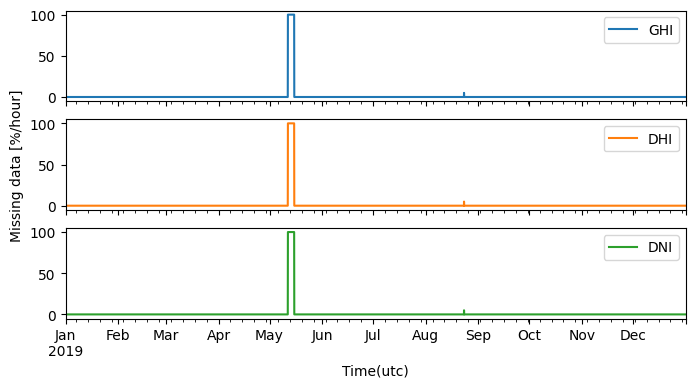

In [3]:
df = df.asfreq('1min') # Convert TimeSeries to specified frequency
print('Missing rows added: {:.1f} %'.format((df.shape[0]-original_entries)/df.shape[0]*100))

axes = df[['GHI', 'DHI', 'DNI']].isna().astype(float).resample('1h').sum().divide(60/100).plot(subplots=True, figsize=(8,4), rot=0) # Plot missing data
axes[1].set_ylabel('Missing data [%/hour]')

for c in ['GHI', 'DHI', 'DNI']:
    print('Missing data {}: {:.1f} %'.format(c, df[c].isna().sum()/df.shape[0]*100))

<br>

## Two-dimensional visual inspection
In the visualization of the raw data in Section 5.2, it was possible to detect large gaps, extreme values, and seasonal variations. However, the daily variations was smothered and pratically indistinguisable due to the large amount of data. To overcome this limitation, a two-dimensional visualization method is presented in this section, where the x-axis coresponds to the day, the y-axis corresponds to the time of day, and the pixel color corresponds to the measurement value. The strength of this two-dimensional method is that each data point is visible, allowing for both intra-day and seasonal trends to be observe. This is particularly useful for detecting errors over time, such as time shifts, missing data, and possibly shading.

To add structure to the 2D plots, we will plot the sunrise and sunset times, which are calculated as:

In [4]:
days = pd.date_range(df.index[0], df.index[-1]) # List of days for which to calculate sunrise/sunset

sunrise_sunset = pvlib.solarposition.sun_rise_set_transit_spa(days, latitude=55.791, longitude=12.525)

# Convert sunrise/sunset from Datetime to hours (decimal)
sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.hour + sunrise_sunset['sunrise'].dt.minute/60
sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.hour + sunrise_sunset['sunset'].dt.minute/60

Next, the 2D DataFrame is created and plotted:

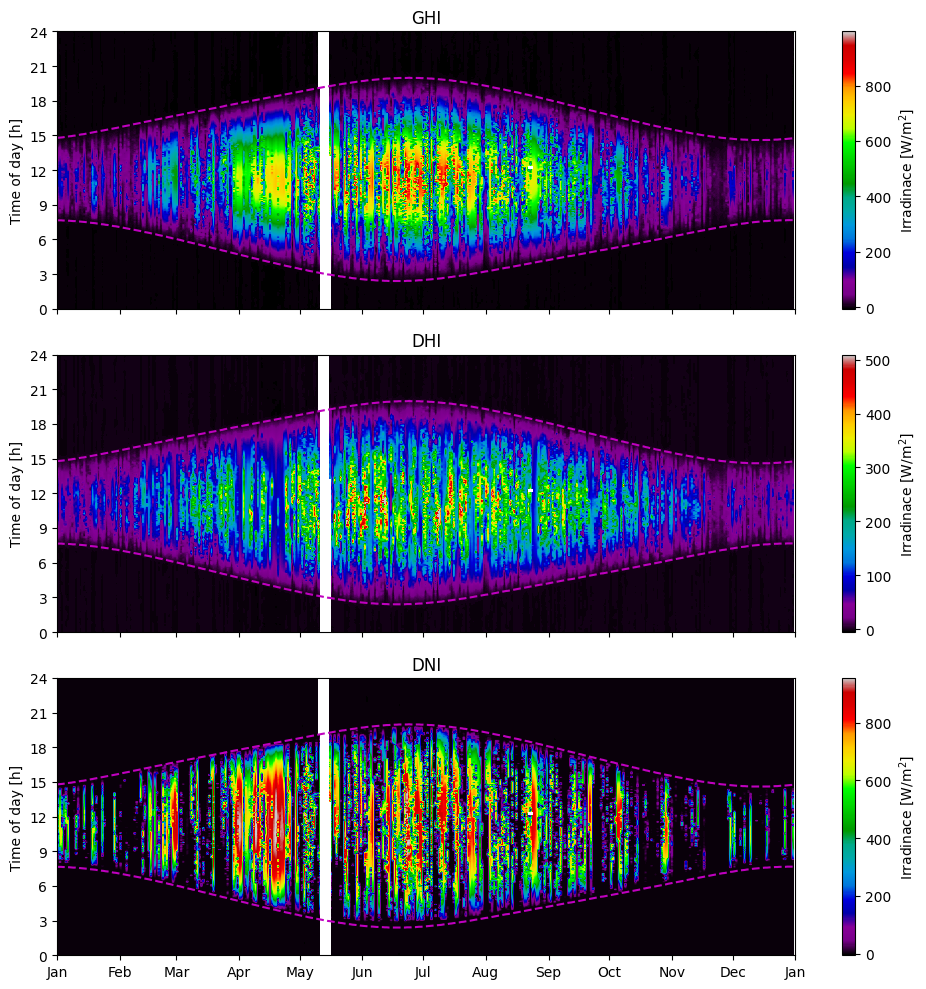

In [5]:
# Creation of the 2D DataFrame, with time-of-day as rows and days as columns
df_2d = df.set_index([df.index.date, df.index.hour+df.index.minute/60]).unstack(level=0)

# Calculate the extents of the 2D plot, in the format [x_start, x_end, y_start, y_end]
xlims = mdates.date2num([df.index[0].date(), df.index[-1].date()])
extent = [xlims[0], xlims[1], 0, 24]

xticks = pd.date_range('2019-01-01', periods=13, freq='MS')

# Generate subplots and plot 2D DataFrame and sunrise/sunset line
fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
for i, c in enumerate(['GHI','DHI','DNI']):
    im = axes[i].imshow(df_2d[c], aspect='auto', origin='lower', cmap='nipy_spectral',
                        extent=extent, vmax=df[c].quantile(0.999))
    axes[i].set_title(c)
    axes[i].xaxis_date()
    axes[i].set_yticks(np.arange(0,25,3))
    axes[i].set_ylabel('Time of day [h]')
    axes[i].plot(mdates.date2num(sunrise_sunset.index), sunrise_sunset[['sunrise', 'sunset']], 'm--')
    cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', label='Irradinace [W/m$^2$]')

axes[-1].set_xticks(mdates.date2num(xticks))
axes[-1].set_xticklabels(xticks.strftime('%b'))

fig.tight_layout()

<br>

## Limit checks

To verify the validity of the measurements, we apply the test proposed by [Long and Dutton](https://bsrn.awi.de/fileadmin/user_upload/bsrn.awi.de/Publications/BSRN_recommended_QC_tests_V2.pdf) and
recommened by the BSRN. This first quality control consists in a set of two tests for each physical quantity: the physically possible limit and the extremely rare limit tests. These are detailed for the GHI, the DHI and the BNI below:

### Physical possible limits
Physically Possible Limits (PPL) check the maximum and minimum limits that can be reached by irradiance, the upper limits depend on the solar zenith angle, the minimal value of solar irradiance must be 0 W/m², but because of the radiative cooling at night the limit is set at -4 W/m², the test applies independently to each of the three components as follows:

$$ -4 \text{ W/m^2} < \text{GHI} < S_a \cdot 1.5 \mu_0^{1.2} + 100 \text{ W/m^2}$$

$$ -4 \text{ W/m$^2$} < \text{DHI} < S_a \cdot 0.95 \mu_0^{1.2} + 50 \text{ W/m^2}$$

$$ -4 \text{ W/m$^2$} < \text{DNI} < S_a $$

### Extremely rare limits
The limits of the "Extremely Rare Limits"(ERL) procedure are more strict than those of the "Physically Possible" test. ERL differs from the PPL test in that the measurements rarely reach these limits, and even if the case is only for short periods of a few seconds to one or two minutes, and also in those measurements violating these limits are not necessarily incorrect but their plausibility should be checked more specifically. The ERL limits are defined as follows:

$$ -2 \text{ W/m$^2$} < \text{GHI} < S_a \cdot 1.2 \mu_0^{1.2} + 50 \text{ W/m$^2$}$$

$$ -2 \text{ W/m$^2$} < \text{DHI} < S_a \cdot 0.75 \mu_0^{1.2} + 30 \text{ W/m$^2$}$$

$$ -2 \text{ W/m$^2$} < \text{DNI} < S_a \cdot 0.95 \mu_0^{0.2} + 10 \text{ Wm$^{-2}$}$$

A graphical representation of these two tests is possible by representing the 10-minute averages of GHI, DHI or DNI as a function of the irradiance received at the top of the atmosphere (TOA). This representation is shown in Fig. 7 where the one-component PPL and ERL tests are represented by green and red lines respectively. In view of the QC equations, it might have been simpler to use the cosine of the zenith solar angle for the graphical representation of the QC. However, we opted for the irradiance at the top of the atmosphere because we judged this quantity to be more intuitive. Finally, another quantity would have been more suitable to represent the quality control of the DNI but we chose to keep the same quantity between the different representations for consistency reasons.

First, it is necessary to calculate the extraterrestrial radiation I$_0$ as used in the equations above:

In [6]:
df['extra_radiation'] = pvlib.irradiance.get_extra_radiation(df.index)
df['mu0'] = np.cos(np.deg2rad(df['zenith'])).clip(lower=0)

C:\Users\arajen\AppData\Local\Temp\ipykernel_29376\1538918722.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
C:\Users\arajen\AppData\Local\Temp\ipykernel_29376\1538918722.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
C:\Users\arajen\AppData\Local\Temp\ipykernel_29376\1538918722.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


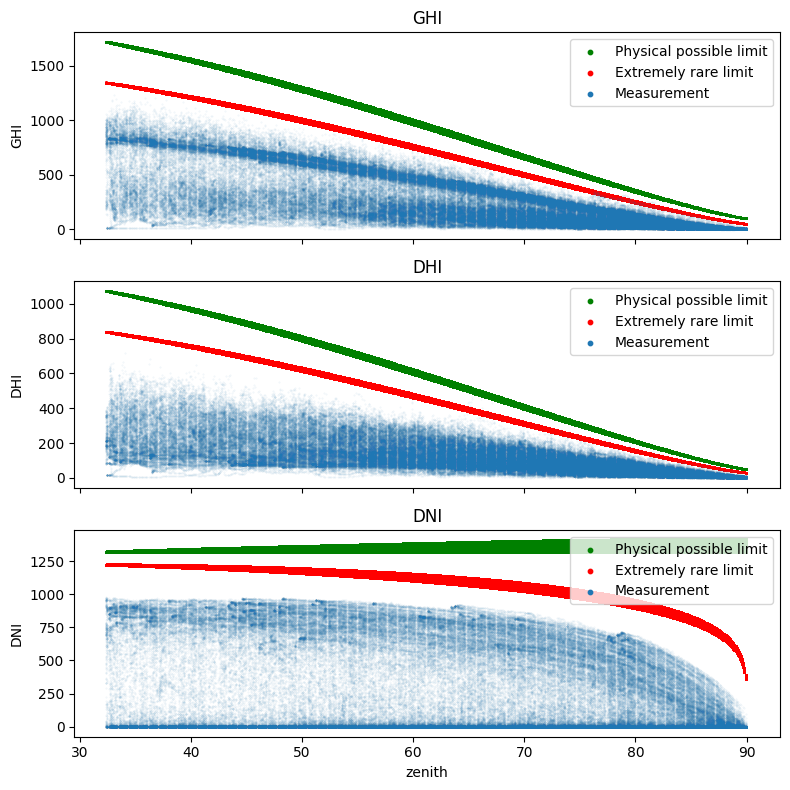

In [7]:
df_limits = pd.DataFrame(index=df.index, data={'zenith':df['zenith']})

# Physical possible limits
df_limits['ppl_upper_GHI'] = 1.5 * df['extra_radiation'] * df['mu0']**1.2 + 100
df_limits['ppl_upper_DHI'] = 0.95 * df['extra_radiation'] * df['mu0']**1.2 + 50
df_limits['ppl_upper_DNI'] = 1 * df['extra_radiation']

# Extremely rare limits
df_limits['erl_upper_GHI'] = 1.2 * df['extra_radiation'] * df['mu0']**1.2 + 50
df_limits['erl_upper_DHI'] = 0.75 * df['extra_radiation'] * df['mu0']**1.2 + 30
df_limits['erl_upper_DNI'] = 0.95 * df['extra_radiation'] * df['mu0']**0.2 + 10

# Plot measured data and limits
fig, axes = plt.subplots(nrows=3, figsize=(8,8), sharex=True)
for i, c in enumerate(['GHI','DHI','DNI']):
    df_limits[df_limits['zenith']<90].plot.scatter(ax=axes[i], x='zenith', y='ppl_upper_{}'.format(c), s=1, c='g', label='Physical possible limit')
    df_limits[df_limits['zenith']<90].plot.scatter(ax=axes[i], x='zenith', y='erl_upper_{}'.format(c), s=1, c='r', label='Extremely rare limit')
    df[df_limits['zenith']<90].plot.scatter(ax=axes[i], x='zenith', y=c, s=0.1, alpha=0.1, xlim=[None,93], label='Measurement')
    axes[i].set_title(c)

    # Configure legend
    legend = axes[i].legend(loc='upper right')
    for handle in legend.legendHandles:
        handle.set_sizes([10])
        handle.set_alpha(1)

fig.tight_layout()

<br>

## Comparison checks

### Diffuse ratio test
Another test recommended by BSRN is the two-component test where the consistency of independent measurements is tested. Where GHI and DHI measurements are available, a comparison of these two measures can be checked for consistency by applying, for GHI>50 W/m², the following two-component tests:

$$ 0.92 < \frac{GHI}{\text{DHI + DNI cos($\theta_z$)}} < 1.08 $$

These tests are not possible for GHI values below 50 W/m². For the visual representation of this test, we have chosen to represent the ratio DHI/GHI as a function of the solar zenith angle. In the plot below, all values of GHI< 50 W/m² are represented by grey dots and the values for which GHI>50 W/m² are represented by blue dots. The limits defined by the two equations above are represented by red lines.

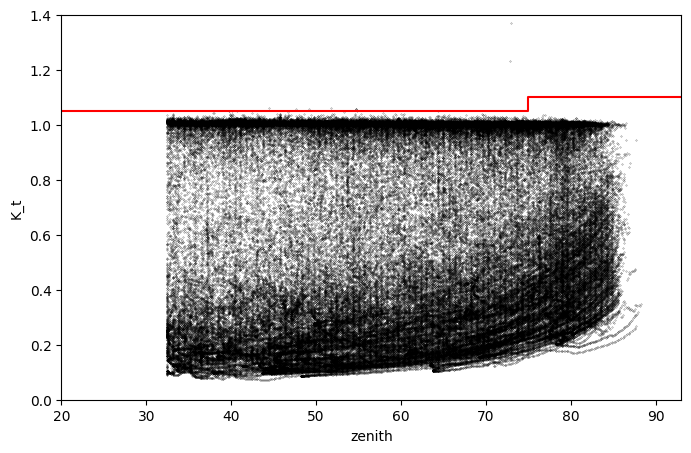

In [8]:
# Calculation of diffuse ratio
df['K_t'] = df['DHI'] / df['GHI']
df.loc[df['zenith']>93, 'K_t'] = np.nan

# Plot diffuse ratio and limit (red)
fig, ax = plt.subplots(figsize=(8,5))
df[df['GHI']>50].plot.scatter(ax=ax, x='zenith', y='K_t', c='k',
                                 s=0.05, alpha=0.75, ylim=[0,1.4], xlim=[20,93])
ax.plot([0,75,75,93], [1.05,1.05,1.10,1.10], c='r')

### Closure-equation test
The three-component test is intended to compare the GHI measured by the pyranometer and GHI calculated from the measured DHI and DNI:

This test only applies when the calculated GHI>50 W/m$^2$.

Here again, we propose a data visualization corresponding to this test. For this, we can note that the three-component test consists in comparing the GHI measured with the pyranometer with an estimate of the GHI obtained with the DNI measured with a pyrheliometer and the DHI measured with a shaded pyranometer using the equation linking the GHI with two other components and the zenith solar angle. Ideally, the ratio of measured and estimated GHI should be 1.0, but instrument characteristics often produce values far from unity.

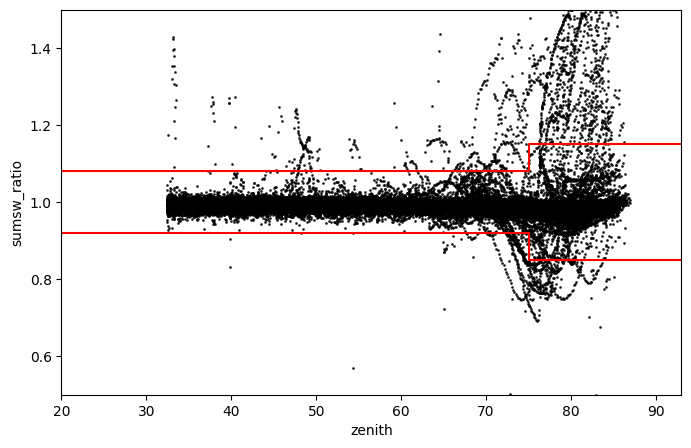

In [9]:
df['sumsw'] = df['DHI'] + df['DNI']*np.cos(np.deg2rad(df['zenith']))
df['sumsw_ratio'] = df['GHI'] / df['sumsw']

fig, ax = plt.subplots(figsize=(8,5))
df[(df['zenith']<93)&(df['sumsw']>50)].plot.scatter(ax=ax, x='zenith', y='sumsw_ratio', alpha=0.76,
                                                  s=1, c='k', xlim=[20,93], ylim=[0.5,1.5])
ax.plot([0,75,75,93], [1.08,1.08,1.15,1.15], c='r')
ax.plot([0,75,75,93], [0.92,0.92,0.85,0.85], c='r')